## Language Models Use Trigonometry to Do Addition

## **Objective**
The goal of this study is to investigate how transformers utilize **hidden state representations** to perform fundamental mathematical operations such as **addition**. Specifically, the study explores:
1. **How numbers are represented within the residual stream** across multiple layers.
2. **How attention and MLP mechanisms interact** to modify and propagate numerical representations.
3. **What underlying algorithms transformers learn** to perform arithmetic operations.


**[Terminology]** Helix: A helix is a three-dimensional curve that winds around a central axis while simultaneously moving along it.

**[Terminology]** General Helix: A curve is called a general helix if its tangent makes a constant angle with a fixed line in space.

## Key Takeaways

### 1. Helical Number Representations
- LLMs encode numbers as a **generalized helix** 

- The periodicity aligns with **Fourier components** (T = [2, 5, 10, 100]):
  - T = 2: Evenness
  - T = 5, 10: Base-10 structure
  - T = 100: Larger-scale periodicity
- This helical representation is **causally relevant** for:
  - Addition
  - Subtraction
  - Integer division
  - Multiplication
  - Modular arithmetic

### 2. Clock Algorithm for Addition
- LLMs perform addition by **manipulating these helices**, extending Nanda et al.'s "Clock" algorithm.
- **Mechanism:**
  1. **Embedding:** Numbers are encoded as helices.
  2. **Attention heads (Layers 9-14):** Move the helices of a and b to the last token.
  3. **MLPs (Layers 14-18):** Construct the a + b helix by manipulating a and b helices.
  4. **MLPs (Layers 19-27):** Read from the a + b helix to produce the final logits.

### 3. Empirical Validation
- **Activation patching** shows that the helical representation is **strongly implicated** in addition.
- Helical representations **outperform PCA-based models** in preserving numerical structure.

### 4. Neuron-Level Investigation
- **Neuron preactivations** show periodic patterns aligned with the helical model.
- The authors hypothesize LLMs use **trigonometric identities** (e.g., `cos(a + b) = cos(a) cos(b) - sin(a) sin(b)`) to construct the sum helix.

### 5. Limitations & Future Directions
- The exact mechanism for transforming helices **remains unclear**.
- Results may not generalize to **models that tokenize numbers digit-by-digit**.
- LLMs may favor helices over linear representations **for robustness to noise**.

---


 <img src="fig1.jpg" width="600"/>


## Problem Definition

### **Background**
Autoregressive transformers are widely used in language models to process sequential data by predicting the next token in a given sequence. These models take as input a sequence of tokens $x_0, ..., x_n$ and generate probability distributions over possible next tokens $x_{n+1}$, enabling tasks such as text generation, mathematical reasoning, and code completion.

### **Formal Definition**
Given a sequence of tokens $x_0, x_1, ..., x_n$, an autoregressive transformer processes each token through a **residual stream** comprising multiple layers of computation. Each layer consists of two primary components: **multi-head self-attention** and **multi-layer perceptrons (MLPs)**. The hidden state representation at layer $l$ for token $i$ is computed as:

$$
h^l_i = h^{l-1}_i + a^l_i + m^l_i
$$

where:
- $h^l_i$ represents the hidden state at layer $l$ for token $i$,
- $a^l_i$ is the output of the **attention mechanism**, computed as:

  $$
  a^l_i = \text{attn}^l(h^{l-1}_1, h^{l-1}_2, ..., h^{l-1}_i)
  $$

- $m^l_i$ is the output of the **MLP component**, computed as:

  $$
  m^l_i = \text{MLP}^l(a^l_i + h^{l-1}_i)
  $$




## Load the model


In [1]:
import torch
import numpy as np
from tqdm import tqdm, trange
from nnsight import LanguageModel
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.exceptions import ConvergenceWarning



/home/eltsai/anaconda3/envs/llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load model# Set the token as an environment variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
full_model_name = 'EleutherAI/gpt-j-6B'#'meta-llama/Llama-3.1-8B'# #'EleutherAI/pythia-6.9b'## # #'google/gemma-2-9b'#'
MODEL_NAME = full_model_name.split('/')[-1]
model = LanguageModel(full_model_name, device_map=device, torch_dtype=torch.bfloat16, dispatch=True)
remote = False
NLAYERS = model.config.num_hidden_layers

device

Some weights of the model checkpoint at EleutherAI/gpt-j-6B were not used when initializing GPTJForCausalLM: ['transformer.h.0.attn.bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.10.attn.bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.12.attn.bias', 'transformer.h.12.attn.masked_bias', 'transformer.h.13.attn.bias', 'transformer.h.13.attn.masked_bias', 'transformer.h.14.attn.bias', 'transformer.h.14.attn.masked_bias', 'transformer.h.15.attn.bias', 'transformer.h.15.attn.masked_bias', 'transformer.h.16.attn.bias', 'transformer.h.16.attn.masked_bias', 'transformer.h.17.attn.bias', 'transformer.h.17.attn.masked_bias', 'transformer.h.18.attn.bias', 'transformer.h.18.attn.masked_bias', 'transformer.h.19.attn.bias', 'transformer.h.19.attn.masked_bias', 'transformer.h.2.attn.bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.20.attn.bi

device(type='cuda', index=0)

In [3]:
NLAYERS

28

In [4]:
model

GPTJForCausalLM(
  (transformer): GPTJModel(
    (wte): Embedding(50400, 4096)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-27): 28 x GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (out_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): GPTJMLP(
          (fc_in): Linear(in_features=4096, out_features=16384, bias=True)
          (fc_out): Linear(in_features=16384, out_features=4096, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f)

<img src="transformers.png" alt="Transformers architecture" width="400">


## Generate addition evaluation data

**Data Generation for Addition Evaluation**
In this section, we generate evaluation data for testing the model's addition capabilities.

We create a dataset of addition problems with numbers ranging from 0 to 99.
For each pair of numbers (a,b), we:
  1. Generate a prompt string asking for the sum
  2. Tokenize the prompt using the model's tokenizer
  3. Calculate the correct answer (a+b)
  4. Tokenize the answer
  5. Store all this information in a pandas DataFrame
The data is then saved to a pickle file for later evaluation.



In [6]:
np.random.seed(42)
def gen_math(mina = 0, maxa = 99):
    data = []
    with torch.no_grad():
        for a in tqdm(range(mina, maxa + 1)):
            for b in range(mina, maxa + 1):
                if MODEL_NAME == 'gpt-j-6B':
                    q_string = f'Output ONLY a number.\n{a}+{b}='
                elif MODEL_NAME == 'Llama-3.1-8B':
                    q_string = f'The following is a correct addition problem. \n{a}+{b}='
                    #q_string = f'The following is a correction addition problem. {a}+0='
                elif MODEL_NAME == 'pythia-6.9b':
                    q_string = f'Output ONLY a number. {a}+{b}='
                q_toks = model.tokenizer(q_string)['input_ids']
                answer = a+b
                answer_tok = model.tokenizer(f'{answer}')['input_ids']
                if MODEL_NAME == 'Llama-3.1-8B':
                    answer_tok = [answer_tok[-1]]
                #print(answer_tok)
                data.append({
                    'a': a,
                    'b': b,
                    'q_string': q_string,
                    'q_tok': q_toks,
                    'answer': answer,
                    'answer_tok': answer_tok
                })
    df = pd.DataFrame(data)
    df.to_pickle(f'data_addition/gen_math/data_addition_{mina}_{maxa}_{MODEL_NAME}.pkl')
    return df


#evaluate_math(mina = 0, maxa = 500)
gen_math(mina = 0, maxa = 99)
#data = get_math_gen()

100%|██████████| 100/100 [00:00<00:00, 134.31it/s]


,a,b,q_string,q_tok,answer,answer_tok
0,0,0,Output ONLY a number.\n0+0=,"[26410, 22224, 257, 1271, 13, 198, 15, 10, 15,...",0,[15]
1,0,1,Output ONLY a number.\n0+1=,"[26410, 22224, 257, 1271, 13, 198, 15, 10, 16,...",1,[16]
2,0,2,Output ONLY a number.\n0+2=,"[26410, 22224, 257, 1271, 13, 198, 15, 10, 17,...",2,[17]
3,0,3,Output ONLY a number.\n0+3=,"[26410, 22224, 257, 1271, 13, 198, 15, 10, 18,...",3,[18]
4,0,4,Output ONLY a number.\n0+4=,"[26410, 22224, 257, 1271, 13, 198, 15, 10, 19,...",4,[19]
...,...,...,...,...,...,...
9995,99,95,Output ONLY a number.\n99+95=,"[26410, 22224, 257, 1271, 13, 198, 2079, 10, 3...",194,[22913]
9996,99,96,Output ONLY a number.\n99+96=,"[26410, 22224, 257, 1271, 13, 198, 2079, 10, 4...",195,[22186]
9997,99,97,Output ONLY a number.\n99+97=,"[26410, 22224, 257, 1271, 13, 198, 2079, 10, 5...",196,[25272]
9998,99,98,Output ONLY a number.\n99+98=,"[26410, 22224, 257, 1271, 13, 198, 2079, 10, 4...",197,[24991]


In [8]:
def evaluate_math(mina = 0, maxa = 99, verbose = False, batch_size = 100):
    df = pd.read_pickle(f'data_addition/gen_math/data_addition_{mina}_{maxa}_{MODEL_NAME}.pkl')
    #df = df.sample(n=15, random_state=42)
    corrects = []
    with torch.no_grad():
        # Process rows in batches
        bar = tqdm(range(0, len(df), batch_size))
        for step in bar:
            batch_df = df.iloc[step:min(step + batch_size, len(df))]
            batch_toks = torch.stack([torch.tensor(x) for x in batch_df['q_tok'].values]).to(device)
            # Combine into single batch tensor
            answer_toks = torch.stack([torch.tensor(x)[0] for x in batch_df['answer_tok'].values])
            # Get model outputs for batch
            with model.trace() as tracer:
                with tracer.invoke(batch_toks) as invoker:
                    pass
                output = model.output.save()
            
            # Get predictions for batch
            logits = output.logits[:,-1].cpu()
            #print(model.tokenizer.batch_decode(output.logits[0].argmax(dim=-1)))
            model_answers = logits.argmax(dim=-1)
            correct = (model_answers == answer_toks).float()
            incorrect_mask = correct == 0
            if incorrect_mask.any() and verbose:
                print("Incorrect answers:")
                print("Expected:", model.tokenizer.batch_decode(answer_toks[incorrect_mask].unsqueeze(-1)))
                print("Got:", model.tokenizer.batch_decode(model_answers[incorrect_mask].unsqueeze(-1)))
            corrects.extend(list(correct))
            bar.set_postfix({'%': np.mean(corrects)})
            
    df['correct'] = corrects
    df.to_pickle(f'data_addition/gen_math/data_addition_correct_{mina}_{maxa}_{MODEL_NAME}.pkl')
    return np.mean(corrects)




In [9]:
evaluate_math(mina = 0, maxa = 99, verbose = False)


  0%|          | 0/100 [00:00<?, ?it/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 100/100 [00:14<00:00,  6.70it/s, %=0.806]


np.float32(0.8061)

## Load Generated Data

In this section, we load and process the generated data from our model's addition task. 

1. We sample a subset of those examples, and map the numerical answers to their corresponding tokens. 
2. We then use these functions to load a sample of 500 correctly predicted addition problems and prepare it for further analysis. 
3. The data includes the operands (a and b), the question string, tokenized inputs/outputs, and correctness flags. 

In [4]:
def get_correct_df(mina = 0, maxa = 99):
    df = pd.read_pickle(f'data_addition/gen_math/data_addition_correct_{mina}_{maxa}_{MODEL_NAME}.pkl')
    return df[df['correct'] == 1]

def get_df_sample(mina = 0, maxa = 99, num_sample = 500, run = False):
    if run:
        df = get_correct_df(mina, maxa)
        df = df.sample(n=num_sample, random_state=42).reset_index(drop=True)
        # Save sampled dataframe
        save_path = f'data_addition/gen_math/data_addition_correct_sample_{mina}_{maxa}_{MODEL_NAME}.pkl'
        df.to_pickle(save_path)
    return pd.read_pickle(f'data_addition/gen_math/data_addition_correct_sample_{mina}_{maxa}_{MODEL_NAME}.pkl')

def get_output_tokens(mina = 0, maxa = 99):
    # answers range from 0, 99 * 2 
    avals, toks = [], []
    for a in range(mina, 2 * maxa + 1):
        atok = model.tokenizer(f'{a}')['input_ids']
        avals.append(a)
        toks.append(atok[0])
    return avals, toks

a, toks = get_output_tokens()
df = get_df_sample(run = True)


In [6]:
ANS_SEQPOS_DICT = {'a': -4, 'b':-2, 'a+b':-1}
df

,a,b,q_string,q_tok,answer,answer_tok,correct
0,9,51,Output ONLY a number.\n9+51=,"[26410, 22224, 257, 1271, 13, 198, 24, 10, 434...",60,[1899],tensor(1.)
1,25,39,Output ONLY a number.\n25+39=,"[26410, 22224, 257, 1271, 13, 198, 1495, 10, 2...",64,[2414],tensor(1.)
2,45,49,Output ONLY a number.\n45+49=,"[26410, 22224, 257, 1271, 13, 198, 2231, 10, 2...",94,[5824],tensor(1.)
3,56,54,Output ONLY a number.\n56+54=,"[26410, 22224, 257, 1271, 13, 198, 3980, 10, 4...",110,[11442],tensor(1.)
4,77,15,Output ONLY a number.\n77+15=,"[26410, 22224, 257, 1271, 13, 198, 3324, 10, 1...",92,[5892],tensor(1.)
...,...,...,...,...,...,...,...
495,4,4,Output ONLY a number.\n4+4=,"[26410, 22224, 257, 1271, 13, 198, 19, 10, 19,...",8,[23],tensor(1.)
496,75,15,Output ONLY a number.\n75+15=,"[26410, 22224, 257, 1271, 13, 198, 2425, 10, 1...",90,[3829],tensor(1.)
497,74,11,Output ONLY a number.\n74+11=,"[26410, 22224, 257, 1271, 13, 198, 4524, 10, 1...",85,[5332],tensor(1.)
498,62,5,Output ONLY a number.\n62+5=,"[26410, 22224, 257, 1271, 13, 198, 5237, 10, 2...",67,[3134],tensor(1.)


In [9]:
target = 'a' #'a'
mina = 0
maxa = 99
batch_size = 80
sample = True

ANS_SEQPOS = ANS_SEQPOS_DICT[target]

a = torch.tensor(df['a'].values)
b = torch.tensor(df['b'].values)
a_b = a+b
hss = []
with torch.no_grad():
    for step in tqdm(range(0, len(df), batch_size)):
        batch_df = df.iloc[step:min(step + batch_size, len(df))]
        tokens = torch.stack([torch.tensor(x) for x in batch_df['q_tok'].values]).to(device)
        layer_hss = []
        with model.trace(validate=False,remote=remote) as tracer:
            with tracer.invoke(tokens, scan=False):
                for layer in range(NLAYERS):
                    if MODEL_NAME == 'Llama-3.1-8B':
                        hs = model.model.layers[layer].input
                    elif MODEL_NAME == 'gpt-j-6B':
                        hs = model.transformer.h[layer].inputs[1]['hidden_states']
                    elif MODEL_NAME == 'pythia-6.9b':
                        hs = model.gpt_neox.layers[layer].input
                    layer_hss.append(hs[:,ANS_SEQPOS].save())
        layer_hss = [layer_hs.detach().cpu() for layer_hs in layer_hss] # gets hs on top of ans_token
        layer_hss = torch.stack(layer_hss, dim=1) # stack along new layer dimension
        hss.append(layer_hss)
hss = torch.cat(hss, dim=0) # concat along batch dimension
# Save nums and hss to file with descriptive name
# Use _FULL in filename if using complete dataset
suffix = '_FULL' if not sample else ''
save_path = f'data/helix_hss/{target}_helix_data_{mina}_{maxa}{suffix}_{MODEL_NAME}.pt'
# Create directory if it doesn't exist
os.makedirs('data/helix_hss', exist_ok=True)
# Save tensors
torch.save({
    'a': a,
    'b':b,
    'a+b':a_b,
    'hidden_states': hss
}, save_path)




# run_hs('a', sample = False)
#run_hs('a', sample = True)
#get_nums_hss('a', sample = True)

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00,  8.86it/s]


In [10]:
def get_nums_hss(target, mina = 0,maxa = 99, sample = False):
    suffix = '_FULL' if not sample else ''
    save_path = f'data/helix_hss/{target}_helix_data_{mina}_{maxa}{suffix}_{MODEL_NAME}.pt'
    obj = torch.load(save_path, weights_only=True)
    a,b,a_b, hss = obj['a'], obj['b'], obj['a+b'], obj['hidden_states']
    return a,b,a_b, hss
# hss is a tensor containing hidden states from each layer of the model
# Shape: [batch_size, num_layers, hidden_dim]
# - batch_size: number of examples in the dataset
# - num_layers: number of transformer layers (28 for GPT-J)
# - hidden_dim: dimension of hidden states (4096 for GPT-J)
# Hidden states are captured at the answer token position for each arithmetic problem
a,b,a_b, hss = get_nums_hss('a')

In [14]:
a[0], b[0], a_b[0], hss[0].shape

(tensor(9), tensor(51), tensor(60), torch.Size([28, 4096]))

In [16]:
hss[0][0]

tensor([-0.0076,  0.0048, -0.0003,  ..., -0.0287,  0.0079,  0.0200],
       dtype=torch.bfloat16)

In [12]:
a.shape, b.shape, a_b.shape, hss.shape


(torch.Size([500]),
 torch.Size([500]),
 torch.Size([500]),
 torch.Size([500, 28, 4096]))

## PCA Functions


This section performs Principal Component Analysis (PCA) on the hidden states of the numbers.

The functions include:
1. run_pca: Performs PCA on the hidden states for a given target variable
2. get_pca: Retrieves the PCA components for a specific layer and target variable
3. get_pca_data: Retrieves the PCA data for a specific layer and target variable


In [7]:
def run_pca(target, mina = 0, maxa = 99, NUM_PCA = 100):
    _,_,_, hss = get_nums_hss(target, mina, maxa) # we want the full thing for a pca
    pca_components = {}
    for layer in tqdm(range(hss.shape[1])):
        hs = hss[:,layer]
        # Convert to numpy for sklearn
        hs_numpy = hs.float().numpy()
        # Fit PCA without dimensionality reduction
        pca = PCA(n_components=NUM_PCA)# None
        pca.fit(hs_numpy)
        # Store components for this layer
        pca_components[layer] = {
            'explained_variance_ratio': pca.explained_variance_ratio_,
            'components': pca.components_,
            'singular_values': pca.singular_values_,
            'mean': pca.mean_
        }
    # Save PCA components to file with descriptive name
    save_path = f'data/helix_pca/{target}_pca_data_{mina}_{maxa}_{MODEL_NAME}.pt'
    # Create directory if it doesn't exist
    os.makedirs('data/helix_pca', exist_ok=True)
    # Save dictionary
    torch.save(pca_components, save_path)
    return pca_components

def get_pca(target, layer, mina = 0, maxa = 99):
    save_path = f'data/helix_pca/{target}_pca_data_{mina}_{maxa}_{MODEL_NAME}.pt'
    pca_data = torch.load(save_path, weights_only = False)[layer]
    return pca_data

run_pca('b')
pca_data = get_pca('b', 18)

  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [00:21<00:00,  1.28it/s]


## Investigating Numerical Structure

### Linear Structure

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Generated hidden states for 100


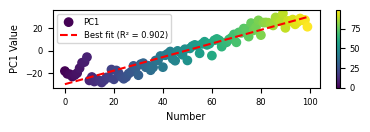

In [20]:
from sklearn.preprocessing import StandardScaler
COL_WIDTH = 3.25
TWO_COL_WIDTH = 6.75

plt.rcParams.update({
    'font.size': 10,               # Default text size
    'axes.titlesize': 7,          # Title size for axes
    'axes.labelsize': 7,          # Axis label size
    'xtick.labelsize': 6,         # X-axis tick label size
    'ytick.labelsize': 6,         # Y-axis tick label size
    'legend.fontsize': 6,         # Legend font size
    'figure.titlesize': 10,        # Overall figure title size
})
def get_nums_hidden_states(mina = 0,maxa = 99):
    nums = np.linspace(mina, maxa, maxa-mina+1)
    tokens = torch.tensor(model.tokenizer([f'{int(num)}' for num in nums])['input_ids'])
    activations = []
    with torch.no_grad():
        with model.trace(validate=False,remote=remote) as tracer:
            with tracer.invoke(tokens, scan=False):
                for layer in range(NLAYERS):
                    activations.append(model.transformer.h[layer].inputs[1]['hidden_states'][:,-1].save())
    act = torch.stack(activations).detach().cpu()
    print(f'Generated hidden states for {len(nums)}')
    return nums, act



def get_pc1(mina, maxa, skip0, layer):
    nums, hss = get_nums_hidden_states(mina, maxa)
    hs = hss[layer].cpu().float().numpy()
    # Perform PCA
    
    # Scale the data
    scaler = StandardScaler()
    hs_scaled = scaler.fit_transform(hs)
    
    # Get first principal component
    pca = PCA(n_components=1)
    pc1_vals = pca.fit_transform(hs_scaled).flatten()
    
    # Print variance explained by PC1
    
    # Create plot
    plt.figure(figsize=(1.25*COL_WIDTH, 1.25*0.35*COL_WIDTH))
    
    # Create scatter plot colored by number value
    scatter = plt.scatter(nums, pc1_vals, c=nums, cmap='viridis', label = 'PC1')
    
    # Calculate line of best fit
    slope, intercept = np.polyfit(nums, pc1_vals, 1)
    line_x = nums
    line_y = slope * line_x + intercept
    
    # Calculate R^2
    r_squared = np.corrcoef(nums, pc1_vals)[0,1]**2
    
    # Plot line of best fit
    plt.plot(line_x, line_y, 'r--', label=f'Best fit (R² = {r_squared:.3f})')
    
    # Add colorbar
    plt.colorbar(scatter)
    
    plt.xlabel('Number')
    plt.ylabel('PC1 Value')
    
    plt.legend()
    plt.tight_layout()
    # Create directory if it doesn't exist
    # Save figure with informative filename
    # plt.savefig(f'paper_figures/figure_2/pc1_layer{layer-1}_range{mina}-{maxa}_skip0={skip0}_{MODEL_NAME}.pdf', 
    #             bbox_inches='tight', dpi = 300)
    plt.show()

get_pc1(mina = 0, maxa = 99, skip0 = False, layer = 1)

### PCA Interpretation

PC1 captures **the strongest numerical trend** in how numbers are represented.

If numbers were linearly embedded, PC1 would strongly correlate with numerical magnitude.

However, nonlinear patterns (e.g., periodic structures) appear in higher components, hinting at a helical representation.


In [23]:
mina, maxa = 0, 99
layer = 1
nums, hss = get_nums_hidden_states(mina, maxa)
hs = hss[layer].cpu().float().numpy()
# Perform PCA

# Scale the data
scaler = StandardScaler()
hs_scaled = scaler.fit_transform(hs)

# Get first principal component
pca = PCA(n_components=1)
pc1_vals = pca.fit_transform(hs_scaled).flatten()

Generated hidden states for 100


In [26]:
nums.shape, hss.shape, pc1_vals.shape

((100,), torch.Size([28, 100, 4096]), (100,))

In [27]:
pc1_vals[0]

np.float32(-18.110722)

## Fourier Transform

We analyze the frequency components of the hidden state representations using Fourier transforms. 

By decomposing the hidden states into their constituent frequencies, we can identify any periodic patterns or oscillations in how the model represents numbers. 

This analysis helps reveal the underlying structure of the model's numerical representations and complements our earlier PCA findings about potential helical patterns.


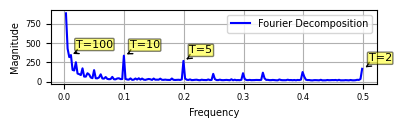

In [29]:
from scipy.fft import fft, fftfreq

plt.rcParams.update({
    'font.size': 8,               # Default text size
    'axes.titlesize': 7,          # Title size for axes
    'axes.labelsize': 7,          # Axis label size
    'xtick.labelsize': 6,         # X-axis tick label size
    'ytick.labelsize': 6,         # Y-axis tick label size
    'legend.fontsize': 7,         # Legend font size
    'figure.titlesize': 10,        # Overall figure title size
})
def get_nums_hss(mina = 0,maxa = 99):
    nums = np.linspace(mina, maxa, maxa-mina+1)
    tokens = torch.tensor(model.tokenizer([f'{int(num)}' for num in nums])['input_ids'])
    activations = []
    with torch.no_grad():
        with model.trace(validate=False,remote=remote) as tracer:
            with tracer.invoke(tokens, scan=False):
                for layer in range(NLAYERS):
                    activations.append(model.transformer.h[layer].inputs[1]['hidden_states'][:,-1].save())
    act = torch.stack(activations).detach().cpu()
    return nums, act

def ff(mina = 0, maxa = 500, layer = 0):
    
    nums, hss = get_nums_hss(mina, maxa)
    hss_np = hss[layer].float().cpu().numpy()
    hss_centered = hss_np# - np.mean(hss_np, axis=0, keepdims=True)
    # Apply Hamming window
    window = np.hamming(hss_np.shape[0])[:, np.newaxis]
    fft_result = fft(hss_centered, axis=0)
    # Get frequencies
    n_samples = hss_np.shape[0]
    freqs = fftfreq(n_samples, d=1)  # d=1 since numbers are 1 unit apart
    # Calculate magnitude spectrum
    magnitude_spectrum = np.abs(fft_result)**2
    # Average across hidden dimensions to get overall frequency importance
    avg_magnitude = np.mean(magnitude_spectrum, axis=1)
    # Plot only positive frequencies (first half)
    positive_freq_mask = freqs > 0
    plt.figure(figsize=(1.25*COL_WIDTH, 1.25*0.325*COL_WIDTH))
    plt.plot(freqs[positive_freq_mask], avg_magnitude[positive_freq_mask],label = f'Fourier Decomposition', color = 'b')
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.xticks()
    plt.yticks()
    
    # Label specific periods
    periods_to_label = [2, 5, 10, 100]
    for period in periods_to_label:
        freq = 1/period
        # Find the closest frequency in our data
        idx = np.argmin(np.abs(freqs[positive_freq_mask] - freq))
        mag = avg_magnitude[positive_freq_mask][idx]
        plt.annotate(f'T={period}', 
                    xy=(freq, mag),
                    xytext=(4, 4),
                    textcoords='offset points',
                    ha='left',
                    va='bottom',
                    bbox=dict(boxstyle='round,pad=0.1', fc='yellow', alpha=0.5),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    #plt.savefig(f'paper_figures/figure_2/fourier_{MODEL_NAME}.pdf', dpi =300, bbox_inches = 'tight')
    plt.show()

ff(mina = 0, maxa = 360, layer = 1)


Through the Fourier transform to the hidden state representations of numbers in GPT-J’s residual stream. 

The analysis reveals that these embeddings exhibit **strong periodicity**, with dominant frequency components at `T = [2, 5, 10, 100]`. These periodic structures suggest that LLMs represent numbers not just as linear embeddings but also as cyclical patterns — a key characteristic of a generalized helix. The presence of a T = 10 component aligns with the base-10 structure of numbers, while T = 2 likely captures even-odd distinctions.

## Fitting A Helical Representation

### Mathematical Definition of a Helix

**1. Standard 3D Helix**

A helix in three-dimensional space with **radius** $ r $ and **pitch** $ p $ is defined as:

$x = r \cos(t), y = r \sin(t), z = \frac{p}{2\pi} t$

where:
- $ t $ is a continuous parameter (often representing time or angle in radians),
- $ r $ is the radius of the helix,
- $ p $ is the pitch, which determines how far the helix moves along the z-axis per revolution.

**2. Generalized Helix in LLMs**

The paper suggests that **LLMs represent numbers as a generalized helix**, incorporating both linear and periodic components.

A number $ a $ is embedded as:

$h(a) = C B(a)^T$

where:

$
B(a) =
\begin{bmatrix}
a \\
\cos\left(\frac{2\pi}{T_1} a\right) \\
\sin\left(\frac{2\pi}{T_1} a\right) \\
\cos\left(\frac{2\pi}{T_2} a\right) \\
\sin\left(\frac{2\pi}{T_2} a\right) \\
\vdots \\
\cos\left(\frac{2\pi}{T_k} a\right) \\
\sin\left(\frac{2\pi}{T_k} a\right)
\end{bmatrix}
$

- $ T_1, T_2, \dots, T_k $ are the periodic components (e.g., 2, 5, 10, 100 from the paper),
- $ C $ is a transformation matrix that maps the **basis functions** into the model’s latent space.

**Matrix Representation**

If we consider a set of numbers $ \{a_1, a_2, \dots, a_n\} $, their helical representation can be written as:

$
H =
\begin{bmatrix}
a_1 & \cos\left(\frac{2\pi}{T_1} a_1\right) & \sin\left(\frac{2\pi}{T_1} a_1\right) & \dots & \cos\left(\frac{2\pi}{T_k} a_1\right) & \sin\left(\frac{2\pi}{T_k} a_1\right) \\
a_2 & \cos\left(\frac{2\pi}{T_1} a_2\right) & \sin\left(\frac{2\pi}{T_1} a_2\right) & \dots & \cos\left(\frac{2\pi}{T_k} a_2\right) & \sin\left(\frac{2\pi}{T_k} a_2\right) \\
\vdots & \vdots & \vdots & \dots & \vdots & \vdots \\
a_n & \cos\left(\frac{2\pi}{T_1} a_n\right) & \sin\left(\frac{2\pi}{T_1} a_n\right) & \dots & \cos\left(\frac{2\pi}{T_k} a_n\right) & \sin\left(\frac{2\pi}{T_k} a_n\right)
\end{bmatrix}
$

Each row represents the **helical embedding** of a number $ a_i $, capturing both its **linear and periodic** properties.

---
**Interpretation**
- The first column represents the **linear** nature of the number.
- The remaining columns encode periodic information with different frequencies.
- The matrix $ C $ applies a transformation to project these representations into a latent space useful for LLMs.

This helical representation allows LLMs to efficiently **manipulate numbers** using trigonometric transformations rather than relying solely on a linear encoding.


In [12]:
def create_features(fit_type, nums, bases = [2,5,10,100], polybase = 9):
    # creates the basis of features of helix regression
    assert fit_type in ['helix', 'poly', 'circle']
    feature_list = []
    for i, num in enumerate(nums):
        if fit_type == 'helix' or fit_type == 'circle':
            for base in bases:
                t_scaled = 2 * np.pi * num / base
                feature_list.extend([np.cos(t_scaled), np.sin(t_scaled)])
        if fit_type == 'helix':
            feature_list.append(num / max(num))  # Add linear term for helix
        if fit_type == 'poly':
            feature_list = [num**power for power in range(1,polybase + 1)]
    feature_list.append(np.ones(nums.shape[1])) # bias term
    helix_features = np.column_stack(feature_list)
    return helix_features

def get_pca(target, layer, mina = 0, maxa = 99):
    save_path = f'data/helix_pca/{target}_pca_data_{mina}_{maxa}_{MODEL_NAME}.pt'
    pca_data = torch.load(save_path, weights_only = False)[layer]
    return pca_data

def get_pca_coords(target, layer, mina = 0, maxa = 99, npca = False, reconstruction = False):
    assert isinstance(npca, bool) or isinstance(npca, int), "npca must be either False or an integer"
    a,b,a_b, hss = get_nums_hss(target, mina, maxa, sample = True) # just take subset
    hss = hss[:,layer]
    pca_data = get_pca(target, layer, mina, maxa)
    pca_comps, pca_mean = pca_data['components'], pca_data['mean']
    #print(hss.shape, pca_comps.shape)
    #assert hss.shape[0] == pca_comps.shape[0] # same batch
    # Project data into PCA space
    hs_numpy = hss.float().numpy()
    hs_centered = hs_numpy - pca_mean
    pca_coords = np.dot(hs_centered, pca_comps.T)
    if npca is False:
        npca = hss.shape[0] # make it full batch
    pca_coords = pca_coords[:, :npca]
    if reconstruction:
        reconstruction = torch.tensor(np.dot(pca_coords, pca_comps[:npca]) + pca_mean)
        mse = torch.mean((reconstruction - hss) ** 2)
        #print(f"MSE between reconstruction and original hidden states: {mse:.6f}")
        return a,b,a_b, reconstruction
    else:
        return a,b,a_b, pca_coords

s = get_pca_coords('a', 5, npca = 3, reconstruction=True)
s = get_pca_coords('b', 5, npca = 3, reconstruction=True)

In [24]:
import warnings
import pickle

def get_train_test_split(frac=0.75):
    """Returns which values of a (0-99) are in train vs test sets"""
    a_values = np.arange(100)
    n_train = int(100 * frac)
    train_a = np.random.choice(a_values, size=n_train, replace=False)
    return train_a

def get_train_mask(a, frac = 0.75):
    train_a = get_train_test_split(frac)
    """Returns boolean mask indicating which elements of a are in training set"""
    return np.isin(a, train_a)

def helix_fit(layer, helix_type, bases=[2,5,10,100], polybase=9, save=True, traintest=False, random=False):
    # target is whatever comes after helix_ in helix_type
    # fitting the helix
    fit_type, target = helix_type.split('_', 1)
    a,b,a_b, hss_projected_n = get_pca_coords(target, layer, mina=0, maxa=99, npca=False, reconstruction=False)
    hss_original = get_nums_hss(target, mina=0, maxa=99)[-1][:,layer]
    pca_data = get_pca(target, layer, mina=0, maxa=99)
    pca_comp, pca_mean = pca_data['components'], pca_data['mean']

    if target == 'a_b':
        nums = np.array([a,b])
    elif target == 'a':
        nums = np.array([a])
    elif target == 'b':
        nums = np.array([b])
    helix_features = create_features(fit_type, nums, bases=bases, polybase=polybase)
    
    # Split data for train/test if requested
    train_mask = None
    if traintest:
        train_mask = get_train_mask(a)
        train_features = helix_features[train_mask]
        train_targets = hss_projected_n[train_mask]
    else:
        train_features = helix_features
        train_targets = hss_projected_n
    
    if random:
        np.random.shuffle(train_features)
    #print(train_features)
        
    # Fit a separate linear model for each reduced dimension
    weights_by_dim = []
    predictions = np.zeros_like(hss_projected_n)
    models = []

    # Suppress convergence warnings during model fitting
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=ConvergenceWarning)
        for i in range(hss_projected_n.shape[1]):
            model = LinearRegression(fit_intercept=False)
            #model = Lasso(alpha=0.01, fit_intercept=False)
            model.fit(train_features, train_targets[:, i])
            models.append(model)
            weights_by_dim.append(model.coef_)
            predictions[:, i] = model.predict(helix_features)  # Predict on all data
            
    # Transform predictions back to original space using SVD components
    predictions_full_space = np.dot(predictions, pca_comp) + pca_mean
    # Calculate MSE in original space
    mse = np.mean((predictions_full_space - hss_original.float().numpy()) ** 2)
    A = np.stack(weights_by_dim, axis=-1)  # Stack weights to form the matrix A
    A_map = A @ pca_comp # 28, 4096

    if save:
        save_dir = 'data/helix_fit/trained_fit'
        os.makedirs(save_dir, exist_ok=True)
        if fit_type == 'poly':
            helix_type = f'{helix_type}_{polybase}'
        else:
            helix_type = f'{helix_type}_{bases}'
        if random:
            helix_type = f'{helix_type}_random'
        os.makedirs(os.path.join(save_dir, helix_type), exist_ok=True)
        save_path = f"{save_dir}/{helix_type}/{helix_type}_fit_layer{layer}_{MODEL_NAME}{'_traintest' if traintest else ''}.pkl"
        with open(save_path, 'wb') as f:
            save_dict = {
                'a': a,
                'b': b,
                'a+b': a_b,
                'predictions_full': predictions_full_space,
                'A_map': A_map,
                'pca_mean': pca_mean,
            }
            pickle.dump(save_dict, f)
    return nums, predictions_full_space, mse, train_mask if traintest else None

x = helix_fit(layer=1, helix_type='helix_a', random = True)
#get_features([[1,2,3,4,5],[2,3,4,5,6], [3,5,7,9,11]], 'poly', [2,5,10,100]).shape
x[-2]

np.float32(0.04511994)

In [25]:
datapath = 'data'
def get_helix(helix_type, layer):
    save_dir = f'{datapath}/helix_fit/trained_fit'
    save_path = f"{save_dir}/{helix_type}/{helix_type}_fit_layer{layer}_{MODEL_NAME}.pkl"
    with open(save_path, 'rb') as f:
        data = pickle.load(f)
    return torch.tensor(data['A_map'][:-1]).float(), get_feature_names()[:-1]

def get_helix_ablation(helix_type, layer):
    helix_abla, _ = get_helix(helix_type, layer)
    helix_abla = np.linalg.pinv(helix_abla).T
    return helix_abla # no need to ablate the bias direction

def get_feature_names(bases = [2,5,10,100]):
    variables = ['a']
    feature_names = []
    for i in range(len(variables)):
        for base in bases:
            feature_names.extend([f'cos({variables[i]}|T = {base})', f'sin({variables[i]}|T = {base})'])
        feature_names.append(variables[i])
    feature_names.append('1')
    return feature_names # All features

def get_helix_coords(layer):
    a,_, _, hss = get_nums_hss(target = 'a')
    hss = hss[:,layer].float()
    # Create random hidden states with same shape as hss
    #hss = torch.randn_like(hss)
    feature_names = get_feature_names()
    helix_comps = get_helix_ablation('helix_a_[2, 5, 10, 100]_random', layer)
    # Get pseudo-inverse of helix components (9,4096) -> (4096,9)mponents
    helix_coords = hss @ helix_comps.T # (100,9)
    return a, helix_coords, feature_names


def get_nums_hss(target, mina = 0,maxa = 99, sample = True):
    suffix = '_FULL' if not sample else ''
    save_path = f'{datapath}/helix_hss/{target}_helix_data_{mina}_{maxa}{suffix}_{MODEL_NAME}.pt'
    obj = torch.load(save_path, weights_only=True)
    a,b,a_b, hss = obj['a'], obj['b'], obj['a+b'], obj['hidden_states']
    return a,b,a_b, hss

## **Formula for the Clock Algorithm**

### **1. Helical Representation of a Number**
A number $ a $ is encoded as a **generalized helix** in a high-dimensional space:

$
\text{helix}(a) = \left[ a, \cos\left(\frac{2\pi}{T_1} a\right), \sin\left(\frac{2\pi}{T_1} a\right), \dots, \cos\left(\frac{2\pi}{T_k} a\right), \sin\left(\frac{2\pi}{T_k} a\right) \right]
$

where:
- $ T_1, T_2, \dots, T_k $ are periodic components (e.g., $ T = 2, 5, 10, 100 $).
- This **combines linear and periodic encoding**, allowing structured numerical manipulation.

---

### **2. Addition in Helical Space**
Instead of performing addition directly, the model **constructs the helix representation of $ a + b $** using trigonometric identities:

$
\cos(a + b) = \cos a \cos b - \sin a \sin b
$

$
\sin(a + b) = \sin a \cos b + \cos a \sin b
$

Thus, the sum is computed as:

$
\text{helix}(a + b) = F(\text{helix}(a), \text{helix}(b))
$

where $ F $ is a transformation function approximated by the **MLPs in the transformer**.

---

### **3. Neural Network Processing**
The **MLP layers** in the model approximate this sum via learned transformations:

$
h_{\text{sum}} = f_{\text{nonlinear}} \left( W_{\text{MLP}} \cdot \begin{bmatrix} \cos a \\ \sin a \\ \cos b \\ \sin b \end{bmatrix} \right)
$

which extracts features needed to compute $ \text{helix}(a + b) $.

---

### **4. Final Output Projection**
After constructing $ \text{helix}(a+b) $, the **last MLP layer** maps this into output logits:

$
\text{logits} = W_{\text{output}} \cdot h_{\text{sum}}
$

where $ W_{\text{output}} $ is a learned weight matrix projecting to the model's output space.

---

### **5. Final Formula for the Clock Algorithm**
$
\text{helix}(a + b) = \left[ a + b, \cos\left(\frac{2\pi}{T_1} (a + b)\right), \sin\left(\frac{2\pi}{T_1} (a + b)\right), \dots \right]
$

This is **constructed by attention heads and MLP layers** using the **Clock Algorithm** to compute structured periodic additions.


## Summary

The authors find that three mid-sized LLMs represent numbers as generalized helices and manipulate them using the interpretable Clock algorithm to compute addition. While LLMs could do addition linearly, we conjecture that LLMs use the Clock algorithm to improve accuracy, analogous to humans using decimal digits (which are a generalized helix with `T = [10, 100, . . . ]`) for addition rather than slide rules.



When humans add numbers, we naturally break numbers into periodic components (digits).

Instead of performing addition in a fully linear space (like using a slide rule, which would be a direct linear computation), we:
1. Align numbers digit by digit (mod 10)
2. Perform carries (mod 100, mod 1000, etc.)
3. Use periodic structures to simplify calculations

Thus, the decimal number system acts like a generalized helix with periodic cycles at `T = [10,100,1000,…]`, which makes addition more structured and accurate.
 
